In [4]:
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import imblearn

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *

In [6]:
df = pd.read_json('full_cleaned_text_file_with_labels.json', lines=True)

ValueError: Unexpected character found when decoding 'false'

In [ ]:
df.head()

,cleaned_html,label
0,,1700
1,1 U.S. 20 1 Dall. 20 1 L.Ed. 19 ANONYMOUS. No....,1700
2,1 U.S. 18 1 Dall. 18 1 L.Ed. 18 The Lessee of ...,1700
3,1 U.S. 194 1 Dall. 194 1 L.Ed. 96 Gerardv.La C...,1700
4,1 U.S. 210 1 Dall. 210 1 L.Ed. 104 Pollardv.Sh...,1700


In [5]:
filter = df["cleaned_html"] != ""
filtered_df = df[filter]
filtered_df = filtered_df.dropna()

filtered_df['length_text'] = filtered_df['cleaned_html'].apply(len)
print(filtered_df['length_text'].max())
fig = px.histogram(filtered_df,
                   x="length_text",
                   template='plotly_white',
                  )
fig.update_layout(
    title={
        'text': "Lengths of Cleaned HTML column",
        'x' : 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Histogram of Text Opinion Lengths').update_xaxes(title='Number of Words')
fig.show()

785988


2000    26977
1900    23179
1800     9762
1700      137
Name: label, dtype: int64


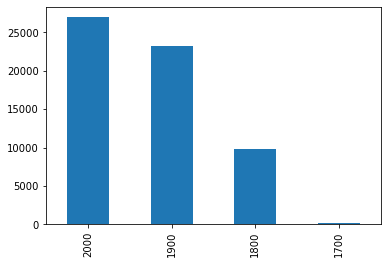

In [6]:
filtered_df['label'].value_counts().plot(kind='bar')
print(filtered_df['label'].value_counts())

In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
dictionary = {1700: 0, 1800: 1, 1900: 2, 2000: 3}

In [19]:
X = []
sentences = list(filtered_df["cleaned_html"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = filtered_df['label'].replace(dictionary)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [21]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 1000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
embeddings_dict = {}

glove_file = open('glove.42B.300d.txt', encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:])
    embeddings_dict[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
import os
import tensorflow as tf
from keras import callbacks

checkpoint_path = "checkpoints/{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(4, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 300)         54597600  
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 54,817,764
Trainable params: 220,164
Non-trainable params: 54,597,600
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

Train on 38435 samples, validate on 9609 samples
Epoch 1/5
17472/38435 [============>.................] - ETA: 48:45 - loss: 0.7285 - acc: 0.7006

: 

: 

In [30]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

KeyError: 'acc'

In [31]:
model.save('saved_model')